              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.92      0.95      0.93        81

    accuracy                           0.88        88
   macro avg       0.46      0.48      0.47        88
weighted avg       0.84      0.88      0.86        88



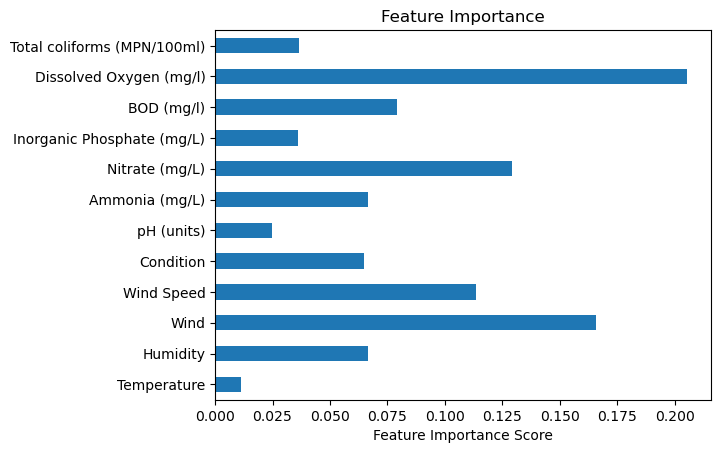

0.875

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Condition', 'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Convert target to categorical
merged_df[target] = pd.to_numeric(merged_df[target])  # Ensure target is numeric first

# Binarize the target for classification (example threshold, adjust as needed)
merged_df['Phytoplankton_Class'] = (merged_df[target] > 1000).astype(int)  # Example threshold for classification

# Handle missing values if any
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df['Phytoplankton_Class']  # Use the classification target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting model for classification
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = gb_classifier.predict(X_test)

# Generate and print classification report
print(classification_report(y_test, y_pred, zero_division='warn'))

# Optionally, plot features importance
feature_importance = pd.Series(gb_classifier.feature_importances_, index=features)
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance')
plt.show()

accuracy_score(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.92      1.00      0.96        81

    accuracy                           0.92        88
   macro avg       0.46      0.50      0.48        88
weighted avg       0.85      0.92      0.88        88



E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


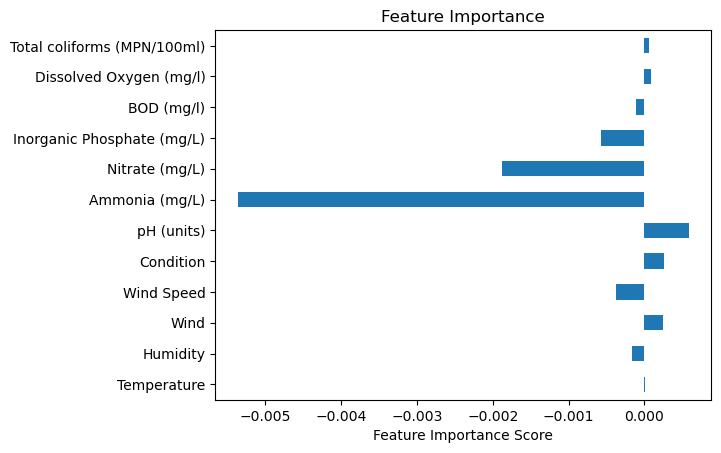

0.9204545454545454

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Condition', 'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Convert target to categorical
merged_df[target] = pd.to_numeric(merged_df[target])  # Ensure target is numeric first

# Binarize the target for classification (example threshold, adjust as needed)
merged_df['Phytoplankton_Class'] = (merged_df[target] > 1000).astype(int)  # Example threshold for classification

# Handle missing values if any
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df['Phytoplankton_Class']  # Use the classification target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM model for classification
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Generate and print classification report
print(classification_report(y_test, y_pred, zero_division='warn'))

# Optionally, plot features importance (SVM does not provide feature importances directly)
# You can use coefficients for linear kernel as feature importances
if svm_classifier.kernel == 'linear':
    feature_importance = pd.Series(svm_classifier.coef_[0], index=features)
    feature_importance.plot(kind='barh')
    plt.xlabel('Feature Importance Score')
    plt.title('Feature Importance')
    plt.show()

accuracy_score(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.92      0.95      0.93        81

    accuracy                           0.88        88
   macro avg       0.46      0.48      0.47        88
weighted avg       0.84      0.88      0.86        88



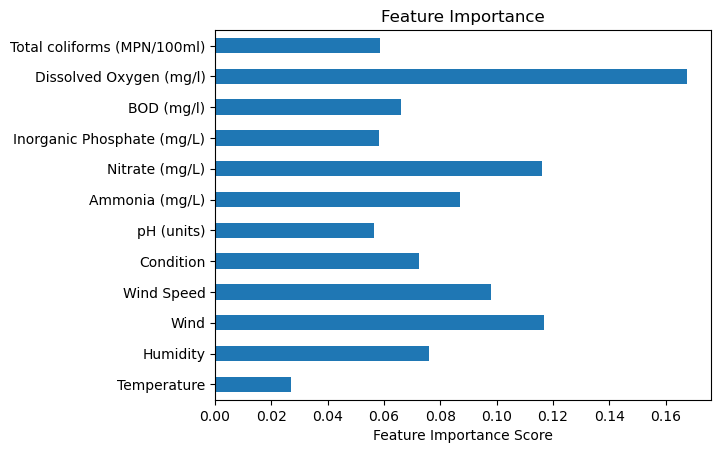

Accuracy: 0.875


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Condition', 'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Convert target to categorical
merged_df[target] = pd.to_numeric(merged_df[target])  # Ensure target is numeric first

# Binarize the target for classification (example threshold, adjust as needed)
merged_df['Phytoplankton_Class'] = (merged_df[target] > 1000).astype(int)  # Example threshold for classification

# Handle missing values if any
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df['Phytoplankton_Class']  # Use the classification target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting and Random Forest models
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize Voting Classifier with both models
voting_classifier = VotingClassifier(estimators=[('gb', gb_classifier), ('rf', rf_classifier)], voting='soft')

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Make predictions
y_pred = voting_classifier.predict(X_test)

# Generate and print classification report
print(classification_report(y_test, y_pred, zero_division='warn'))

# Optionally, plot features importance (only if using models that provide it)
# We can average the feature importances from both models
gb_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)

gb_importances = gb_classifier.feature_importances_
rf_importances = rf_classifier.feature_importances_
average_importances = (gb_importances + rf_importances) / 2

feature_importance = pd.Series(average_importances, index=features)
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))


In [23]:
import pickle
import pandas as pd
import numpy as np

# Load the saved Random Forest model
with open('model_saved.pkl', 'rb') as model_file:
    rf_classifier = pickle.load(model_file)

# Define mappings for Wind and Condition columns
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Function to predict phytoplankton count class based on weather data
def predict_phytoplankton(temperature, humidity, wind, wind_speed, condition):
    # Convert wind and condition to numeric
    wind = wind_mapping.get(wind, np.nan)
    condition = condition_mapping.get(condition, np.nan)
    
    # Create a dataframe for the input
    input_data = pd.DataFrame({
        'Temperature': [temperature],
        'Humidity': [humidity],
        'Wind': [wind],
        'Wind Speed': [wind_speed],
        'Condition': [condition],
        'pH (units)': [np.nan],  # Placeholder for missing features
        'Ammonia (mg/L)': [np.nan],  # Placeholder for missing features
        'Nitrate (mg/L)': [np.nan],  # Placeholder for missing features
        'Inorganic Phosphate (mg/L)': [np.nan],  # Placeholder for missing features
        'BOD (mg/l)': [np.nan],  # Placeholder for missing features
        'Dissolved Oxygen (mg/l)': [np.nan],  # Placeholder for missing features
        'Total coliforms (MPN/100ml)': [np.nan]  # Placeholder for missing features
    })

    # Fill NaN values with mean values of the training set (example)
    # This assumes you have calculated these mean values before
    # For example:
    # mean_values = merged_df.mean()
    mean_values = {
        'pH (units)': 7.5,
        'Ammonia (mg/L)': 0.5,
        'Nitrate (mg/L)': 2.0,
        'Inorganic Phosphate (mg/L)': 0.1,
        'BOD (mg/l)': 1.5,
        'Dissolved Oxygen (mg/l)': 8.0,
        'Total coliforms (MPN/100ml)': 100
    }
    
    input_data.fillna(mean_values, inplace=True)

    # Predict using the trained model
    prediction = rf_classifier.predict(input_data)
    
    return prediction[0]

# Example usage
temperature = 25  # example temperature
humidity = 60  # example humidity
wind = 'NNE'  # example wind direction
wind_speed = 10  # example wind speed
condition = 'Partly Cloudy'  # example weather condition

phytoplankton_class = predict_phytoplankton(temperature, humidity, wind, wind_speed, condition)
print(f'Predicted Phytoplankton Class: {phytoplankton_class}')


Predicted Phytoplankton Class: 1


Mean Squared Error on Training Data: 1043361040.1343976
Mean Squared Error on Test Data: 2627491644.1429977
R-squared on Training Data: 0.9091447692725959
R-squared on Test Data: -1.6395205956924772
Baseline Mean Squared Error: 11483775141.849876


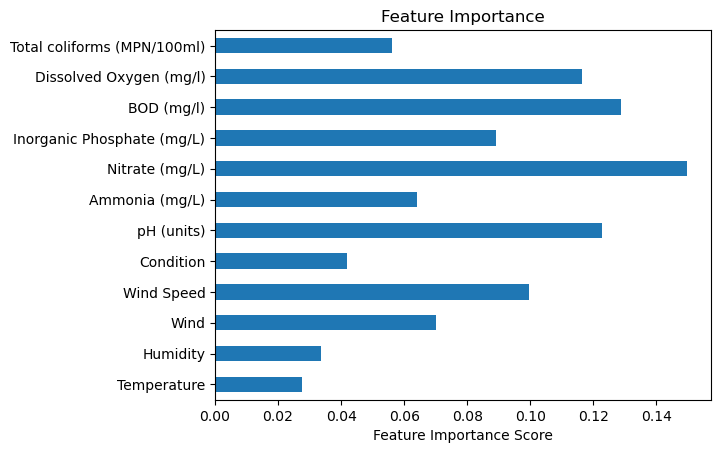

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import re
import pickle
import matplotlib.pyplot as plt

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Condition', 
             'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Inorganic Phosphate (mg/L)', 
             'BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Convert target to numeric
merged_df[target] = pd.to_numeric(merged_df[target], errors='coerce')

# Handle missing values if any
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]  # Use the continuous target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model for regression
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Save the trained model using pickle
with open('random_forest_regressor_model.pkl', 'wb') as model_file:
    pickle.dump(rf_regressor, model_file)

# Make predictions
y_train_pred = rf_regressor.predict(X_train)  # Predictions for training data
y_test_pred = rf_regressor.predict(X_test)  # Predictions for test data

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Mean Squared Error on Training Data: {mse_train}')
print(f'Mean Squared Error on Test Data: {mse_test}')
print(f'R-squared on Training Data: {r2_train}')
print(f'R-squared on Test Data: {r2_test}')

# For comparison, calculate MSE for a simple baseline model
y_train_mean = y_train.mean()
y_train_baseline_pred = [y_train_mean] * len(y_train)
mse_baseline = mean_squared_error(y_train, y_train_baseline_pred)
print(f'Baseline Mean Squared Error: {mse_baseline}')

# Optionally, plot feature importance
feature_importance = pd.Series(rf_regressor.feature_importances_, index=features)
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance')
plt.show()


Mean Squared Error on Training Data: 803478181.4010028
Mean Squared Error on Test Data: 5541403544.049365
R-squared on Training Data: 0.9300336194782395
R-squared on Test Data: -4.5667727112153464
Baseline Mean Squared Error: 11483775141.849876


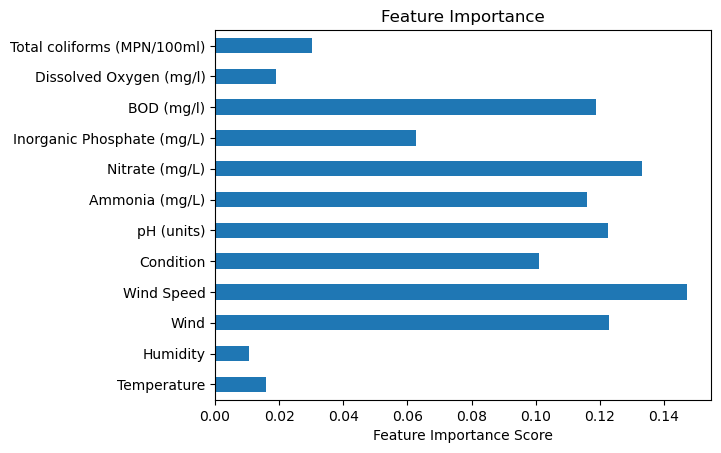

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import re
import pickle
import matplotlib.pyplot as plt

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Condition', 
             'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Inorganic Phosphate (mg/L)', 
             'BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Convert target to numeric
merged_df[target] = pd.to_numeric(merged_df[target], errors='coerce')

# Handle missing values if any
merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]  # Use the continuous target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting model for regression
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)

# Save the trained model using pickle
with open('gradient_boosting_regressor_model.pkl', 'wb') as model_file:
    pickle.dump(gb_regressor, model_file)

# Make predictions
y_train_pred = gb_regressor.predict(X_train)  # Predictions for training data
y_test_pred = gb_regressor.predict(X_test)  # Predictions for test data

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Mean Squared Error on Training Data: {mse_train}')
print(f'Mean Squared Error on Test Data: {mse_test}')
print(f'R-squared on Training Data: {r2_train}')
print(f'R-squared on Test Data: {r2_test}')

# For comparison, calculate MSE for a simple baseline model
y_train_mean = y_train.mean()
y_train_baseline_pred = [y_train_mean] * len(y_train)
mse_baseline = mean_squared_error(y_train, y_train_baseline_pred)
print(f'Baseline Mean Squared Error: {mse_baseline}')

# Optionally, plot feature importance
feature_importance = pd.Series(gb_regressor.feature_importances_, index=features)
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance')
plt.show()


Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300}
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for XGBoost: {'alpha': 0, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}
Gradient Boosting - Mean Squared Error on Training Data: 1133643038.0179582
Gradient Boosting - Mean Squared Error on Test Data: 5011129557.788489
Gradient Boosting - R-squared on Training Data: 0.919996023736569
Gradient Boosting - R-squared on Test Data: -1.2587152712664982
Random Forest - Mean Squared Error on Training Data: 1112393967.7792008
Random Forest - Mean Squared Error on Test Data: 5235405975.735169
Random Forest - R-squared on Training Data: 0.9214956228643277
Random Forest - R-squared on Test Data: -1.3598055672485239
XGBoost - Mean Squared Error on Training Data: 3161501280.2632866
XGBoost - Mean Squared Error on Tes

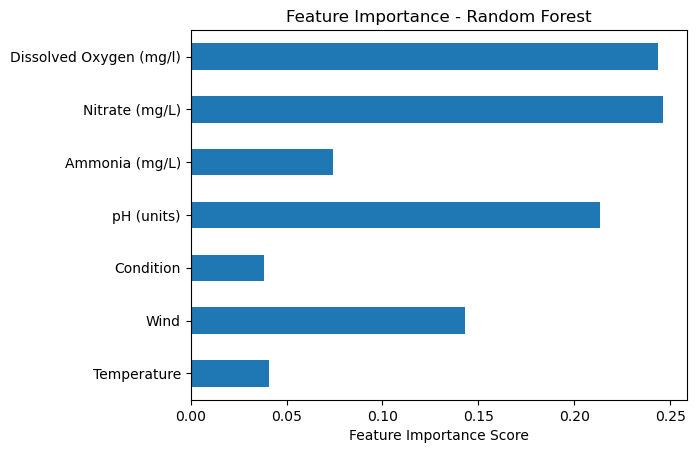

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt

# Load datasets
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# Remove non-numeric characters from weather_df
def remove_non_numeric(value):
    if isinstance(value, str):
        return re.sub(r'[^0-9.]', '', value)
    return value

for column in weather_df.columns:
    if column not in ['Month', 'Wind', 'Condition']:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert to numeric
numeric_columns = [col for col in weather_df.columns if col not in ['Month', 'Wind', 'Condition']]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings
wind_mapping = {'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4, 'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8, 'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12, 'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16, 'VAR': 17, 'CALM': 18}
condition_mapping = {'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4, 'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8, 'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11, 'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14, 'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16, 'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19, 'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21}

# Apply mappings
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Prepare features and target
features = ['Temperature', 'Wind', 'Condition', 'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Dissolved Oxygen (mg/l)']
target = 'Phytoplankton (cells/ml)'

# Convert target to numeric and handle missing values
merged_df[target] = pd.to_numeric(merged_df[target], errors='coerce')
merged_df = merged_df.dropna()

# Split data
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_grid_search = GridSearchCV(gb_regressor, gb_param_grid, cv=5, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train_scaled, y_train)
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_regressor = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_scaled, y_train)
print("Best parameters for Random Forest:", rf_grid_search.best_params_)

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1]
}
xgb_regressor = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(xgb_regressor, xgb_param_grid, cv=5, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X_train_scaled, y_train)
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)

# Evaluate the tuned models
gb_best = gb_grid_search.best_estimator_
rf_best = rf_grid_search.best_estimator_
xgb_best = xgb_grid_search.best_estimator_

# Train and predict
y_train_pred_gb = gb_best.predict(X_train_scaled)
y_test_pred_gb = gb_best.predict(X_test_scaled)
y_train_pred_rf = rf_best.predict(X_train_scaled)
y_test_pred_rf = rf_best.predict(X_test_scaled)
y_train_pred_xgb = xgb_best.predict(X_train_scaled)
y_test_pred_xgb = xgb_best.predict(X_test_scaled)

# Evaluate models
mse_train_gb = mean_squared_error(y_train, y_train_pred_gb)
mse_test_gb = mean_squared_error(y_test, y_test_pred_gb)
r2_train_gb = r2_score(y_train, y_train_pred_gb)
r2_test_gb = r2_score(y_test, y_test_pred_gb)

mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f'Gradient Boosting - Mean Squared Error on Training Data: {mse_train_gb}')
print(f'Gradient Boosting - Mean Squared Error on Test Data: {mse_test_gb}')
print(f'Gradient Boosting - R-squared on Training Data: {r2_train_gb}')
print(f'Gradient Boosting - R-squared on Test Data: {r2_test_gb}')

print(f'Random Forest - Mean Squared Error on Training Data: {mse_train_rf}')
print(f'Random Forest - Mean Squared Error on Test Data: {mse_test_rf}')
print(f'Random Forest - R-squared on Training Data: {r2_train_rf}')
print(f'Random Forest - R-squared on Test Data: {r2_test_rf}')

print(f'XGBoost - Mean Squared Error on Training Data: {mse_train_xgb}')
print(f'XGBoost - Mean Squared Error on Test Data: {mse_test_xgb}')
print(f'XGBoost - R-squared on Training Data: {r2_train_xgb}')
print(f'XGBoost - R-squared on Test Data: {r2_test_xgb}')

# Feature importance for Random Forest
feature_importance = pd.Series(rf_best.feature_importances_, index=features)
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance - Random Forest')
plt.show()


Missing values in merged dataset:
Monitoring Stations            0
Month                          0
Year                           0
pH (units)                     0
Ammonia (mg/L)                 0
Nitrate (mg/L)                 0
Inorganic Phosphate (mg/L)     0
BOD (mg/l)                     0
Dissolved Oxygen (mg/l)        0
Total coliforms (MPN/100ml)    0
Phytoplankton (cells/ml)       0
Day                            0
Time                           0
Temperature                    0
Dew Point                      0
Humidity                       0
Wind                           0
Wind Speed                     0
Wind Gust                      0
Pressure                       0
Precip.                        0
Condition                      0
dtype: int64
Missing values after cleaning:
Monitoring Stations            0
Month                          0
Year                           0
pH (units)                     0
Ammonia (mg/L)                 0
Nitrate (mg/L)                 

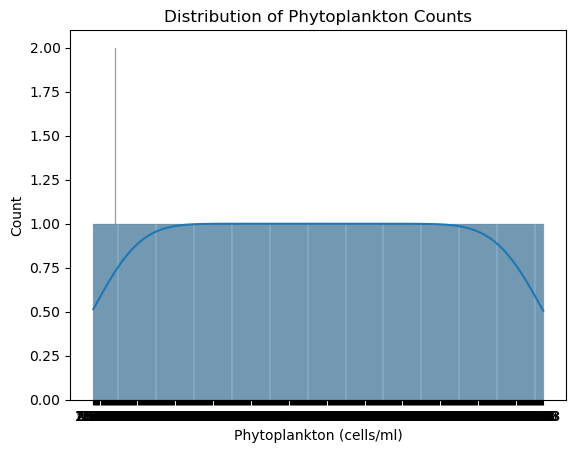

           Monitoring Stations     Month  Year  pH (units)  Ammonia (mg/L)  \
0    Stn. I (Central West Bay)   January  2013        7.68          0.0464   
1    Stn V (Northern West Bay)   January  2013        7.68          0.0824   
2           Stn XV (San Pedro)   January  2013        7.82          0.0678   
3           Stn.XVI (Sta Rosa)   January  2013        7.82          0.0914   
4    Stn. I (Central West Bay)     March  2013        7.82          0.0678   
..                         ...       ...   ...         ...             ...   
435  Stn V (Northern West Bay)  December  2022        7.30          0.0500   
436          Stn XIII (Taytay)  December  2022        8.00          0.0050   
437         Stn XV (San Pedro)  December  2022        7.80          0.0050   
438         Stn.XVI (Sta Rosa)  December  2022        7.60          0.0200   
439       Stn XIX (Muntinlupa)  December  2022        7.70          0.0200   

     Nitrate (mg/L)  Inorganic Phosphate (mg/L)  BOD (mg/l)  \


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Check for missing values
print("Missing values in merged dataset:")
print(merged_df.isnull().sum())

# Drop rows with missing target values
merged_df = merged_df.dropna(subset=['Phytoplankton (cells/ml)'])

# Recheck missing values after dropping
print("Missing values after cleaning:")
print(merged_df.isnull().sum())

# Plot the distribution of the target variable
sns.histplot(merged_df['Phytoplankton (cells/ml)'], kde=True)
plt.title('Distribution of Phytoplankton Counts')
plt.show()

print(merged_df)
# Select relevant features and target
features = ['Temperature', 'Wind', 'Condition', 
             'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 
             'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

# Prepare features and target
X = merged_df[features]
y = merged_df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and train Support Vector Regression model
svr = SVR()

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

cross_val_mse = -cross_val_score(svr, X, y, cv=5, scoring='neg_mean_squared_error')

print("--- Support Vector Regression ---")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Cross-validated MSE scores: {cross_val_mse}")

# Hyperparameter Tuning for SVR
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

grid_search_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, y_train)

print("Best parameters for SVR:", grid_search_svr.best_params_)
print("Best cross-validated MSE for SVR:", -grid_search_svr.best_score_)


In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Load datasets with specified encoding
water_quality_df = pd.read_csv('Overall-dataset-llda(west phyto) assumed_knn_imputed_final2.csv', encoding='latin1')
weather_df = pd.read_csv('Overall-weather-dataset(csv).csv', encoding='iso-8859-1')

# Clean up water_quality_df to remove commas from 'Phytoplankton (cells/ml)'
water_quality_df['Phytoplankton (cells/ml)'] = water_quality_df['Phytoplankton (cells/ml)'].str.replace(',', '')

# List of columns to exclude from transformation
exclude_columns = ['Month', 'Wind', 'Condition']

# Function to remove non-numeric characters from each cell
def remove_non_numeric(value):
    if isinstance(value, str) and value not in exclude_columns:
        # Use regular expression to remove non-numeric characters
        return re.sub(r'[^0-9.]', '', value)
    else:
        return value  # Return unchanged if not a string or in exclude list

# Apply the function to each cell in numeric columns of the dataframe
for column in weather_df.columns:
    if column not in exclude_columns:
        weather_df[column] = weather_df[column].apply(remove_non_numeric)

# Convert the numeric columns to numeric type
numeric_columns = [col for col in weather_df.columns if col not in exclude_columns]
weather_df[numeric_columns] = weather_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Define mappings for Wind column
wind_mapping = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16,
    'VAR': 17, 'CALM': 18  # Assuming VAR and CALM are special cases
}

# Define mappings for Condition column
condition_mapping = {
    'Fair': 1, 'Mostly Cloudy': 2, 'Partly Cloudy': 3, 'Cloudy': 4,
    'Light Rain': 5, 'Light Rain Shower': 6, 'Rain': 7, 'Heavy Rain': 8,
    'Thunder': 9, 'Light Rain with Thunder': 10, 'T-Storm': 11,
    'Heavy Rain Shower': 12, 'Rain Shower': 13, 'Showers in the Vicinity': 14,
    'Thunder in the Vicinity': 15, 'Mostly Cloudy / Windy': 16,
    'Fair / Windy': 17, 'Partly Cloudy / Windy': 18, 'Rain / Windy': 19,
    'Light Rain Shower / Windy': 20, 'Heavy Rain / Windy': 21
}

# Apply mappings to Wind and Condition columns
weather_df['Wind'] = weather_df['Wind'].map(wind_mapping)
weather_df['Condition'] = weather_df['Condition'].map(condition_mapping)

# Aggregate weather data to monthly averages
weather_monthly_avg = weather_df.groupby(['Year', 'Month']).mean().reset_index()

# Merge datasets on 'Month' and 'Year'
merged_df = pd.merge(water_quality_df, weather_monthly_avg, on=['Month', 'Year'])

# Select relevant features and target
features = ['Temperature', 'Humidity', 'Wind', 'Wind Speed', 'Condition', 'pH (units)', 'Ammonia (mg/L)', 'Nitrate (mg/L)', 'Inorganic Phosphate (mg/L)', 'BOD (mg/l)', 'Dissolved Oxygen (mg/l)', 'Total coliforms (MPN/100ml)']
target = 'Phytoplankton (cells/ml)'

merged_df = merged_df.dropna()

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for Grid Search with SVR
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV with SVR
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# Train model with best parameters
best_svr_model = grid_search.best_estimator_

# Make predictions and evaluate
y_pred_best_svr = best_svr_model.predict(X_test_scaled)
mse_best_svr = mean_squared_error(y_test, y_pred_best_svr)
mae_best_svr = mean_absolute_error(y_test, y_pred_best_svr)
r2_best_svr = r2_score(y_test, y_pred_best_svr)

print(f'Optimized SVR - Mean Squared Error: {mse_best_svr}')
print(f'Optimized SVR - Mean Absolute Error: {mae_best_svr}')
print(f'Optimized SVR - R^2 Score: {r2_best_svr}')



Best Parameters: {'C': 100, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'linear'}
Best Score (Negative MSE): -12207400698.419683
Optimized SVR - Mean Squared Error: 1022182884.2227523
Optimized SVR - Mean Absolute Error: 21524.966919928906
Optimized SVR - R^2 Score: -0.026862552154877317
0       5552
1       4294
2       5733
3      18190
4      20927
       ...  
435     1271
436     2199
437     3646
438     2933
439     2823
Name: Phytoplankton (cells/ml), Length: 440, dtype: object
